## Реализация и обучение классификатора отзывов

Задача: классификация отзывов на фильмы (положительный или отрицательный).
Датасет: IMDB.

### Загрузка библиотек

In [66]:
import numpy as np
import tensorflow as tf

print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

2.12.0


### Загрузка датасета IMDB

In [67]:
VOCAB_SIZE = 10000  # Количество слов в словаре

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)

print("Training entries: {}".format(len(train_data)))
print('=====================================')
print("Test entries: {}".format(len(test_data)))
print('=====================================')
print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_data[0]))

Training entries: 25000
Test entries: 25000
Length examples: [218, 189]
Entry example: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 

### Создание функций decode_review и encode_review
Создадим функции для конвертирования индексного представления отзыва в словесный (`decode_review`) и наоборот (`encode_review`).

Функции будут использовать словари `word2idx` и `idx2word` (отображение слова в индекс и индекса в слово)

Кроме обычных слов в словаре будут содержаться специальные слова (токены): `<PAD>`, `<START>`, `<UNKNOWN>`


In [68]:
word_index = tf.keras.datasets.imdb.get_word_index()

word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2

reverse_word_index = dict([(value, key) for key, value in word_index.items()])


# последовательность индексов в текст
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


# текст в последовательность индексов
def encode_review(text):
    words = text.lower().split()
    words = ['<START>'] + words
    idxs = [word_index.get(word, word_index['<UNKNOWN>']) for word in words]
    return idxs


print('Example of a decoded review: \n{}'.format(decode_review(train_data[0])))

Example of a decoded review: 
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNKNOWN> is an amazing actor and now the same being director <UNKNOWN> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNKNOWN> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNKNOWN> to the two little boy's that played the <UNKNOWN> of norman and paul they were just brilliant children are often left out of the <UNKNOWN> list i think because the stars that play them all grown up are such a big profile for the whole film but th

### Проверка работы функций decode_review и encode_review

In [69]:
text = 'hello world'

print(encode_review(text))
print(decode_review(encode_review(text)))

[1, 4825, 182]
<START> hello world


### Приведение всех цепочек в датасете к одной длине с помощью паддинга
Дополним каждый отзыв до длины `MAX_SEQ_LEN` элементами `<PAD>`.

In [70]:
MAX_SEQ_LEN = 256  # Финальная длина последовательности

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_data[0]))

Length examples: [256, 256]
Entry example: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   1

### Создание модели LSTM

In [71]:
EMB_SIZE = 16  # Размер векторного представления (эмбеддинга)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          160000    
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 32)         4224      
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 170,529
Trainable params: 170,529
Non-trainable params: 0
_________________________________________________________________


### Подготовка модели к обучению

In [72]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Разбиение датасета на обучающий и валидационный

In [73]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### Обучение модели

In [74]:
BATCH_SIZE = 512
NUM_EPOCHS = 10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 45s 1s/step - loss: 0.6925 - accuracy: 0.5154 - val_loss: 0.6916 - val_accuracy: 0.5156
Epoch 2/10
30/30 [==============================] - 36s 1s/step - loss: 0.6629 - accuracy: 0.6251 - val_loss: 0.5438 - val_accuracy: 0.7458
Epoch 3/10
30/30 [==============================] - 37s 1s/step - loss: 0.5222 - accuracy: 0.7609 - val_loss: 0.4628 - val_accuracy: 0.8049
Epoch 4/10
30/30 [==============================] - 36s 1s/step - loss: 0.4306 - accuracy: 0.8228 - val_loss: 0.4078 - val_accuracy: 0.8286
Epoch 5/10
30/30 [==============================] - 36s 1s/step - loss: 0.3453 - accuracy: 0.8670 - val_loss: 0.3699 - val_accuracy: 0.8500
Epoch 6/10
30/30 [==============================] - 36s 1s/step - loss: 0.2969 - accuracy: 0.8899 - val_loss: 0.4071 - val_accuracy: 0.8572
Epoch 7/10
30/30 [==============================] - 37s 1s/step - loss: 0.2727 - accuracy: 0.8987 - val_loss: 0.3710 - val_accuracy: 0.8615
Epoch 8/10
30/30 [==

### Оценка качества на тестовом датасете

In [75]:
results = model.evaluate(test_data, test_labels)

print('Test loss: {:.3f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1] * 100))

782/782 [==============================] - 53s 68ms/step - loss: 0.4162 - accuracy: 0.8492
Test loss: 0.416
Test accuracy: 84.92 %


### Графики лосса и точности на обучающем и валидационном датасетах

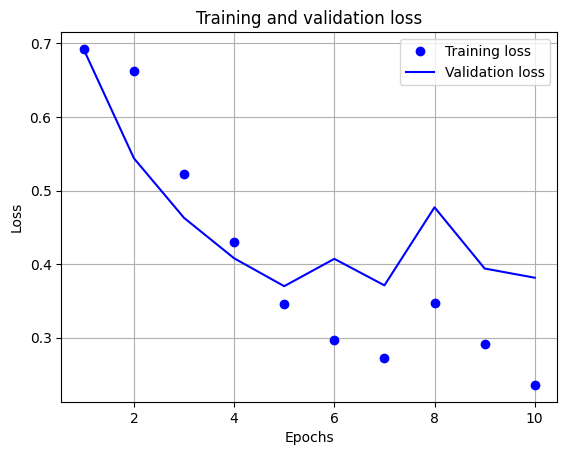

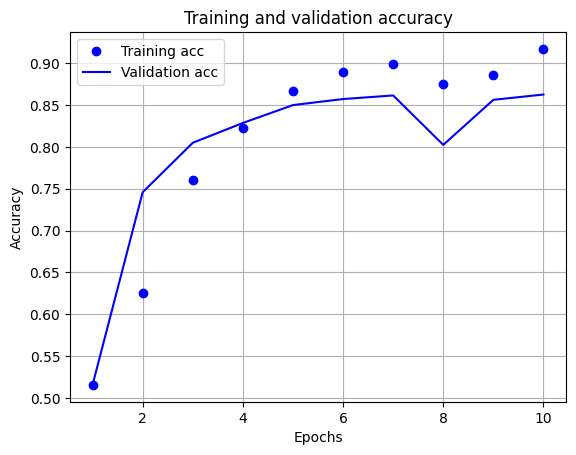

In [77]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

### Тестирование обученной модели на новой последовательности

Проверим работу модели на собственном отзыве.

Напишем текст (отзыв), закодируем его в индексы с помощью `encode_review` и подадим на вход в нейронную сеть, приклеив батч-измерение. Выход из сети -- вероятность того, что отзыв положительный.

In [88]:
text = 'I saw a masterpiece. I really liked this movie it was so fantastic'

encoded = encode_review(text)
prediction = model.predict(np.array(encoded)[None, :])[0, 0]

print(prediction if prediction > 0.5 else 1 - prediction)
print('Positive' if prediction > 0.5 else 'Negative')

1/1 [==============================] - 0s 19ms/step
0.7660819
Positive


In [89]:
text = "I've been waiting for it for so long. The acting leaves much to be desired. I thought the movie would be better"

encoded = encode_review(text)
prediction = model.predict(np.array(encoded)[None, :])[0, 0]

print(prediction if prediction > 0.5 else 1 - prediction)
print('Positive' if prediction > 0.5 else 'Negative')

1/1 [==============================] - 0s 21ms/step
0.9013688191771507
Negative


## Сохранение модели

In [ ]:
model.save('movie_review_classifier.h5')